In [1]:
%matplotlib inline

In [2]:
import warnings
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import matplotlib.animation as mpla
import requests
import json
from pprint import pprint
import geopandas as gpd

warnings.filterwarnings("ignore")

# Find out charge status percentages by LGA

In [3]:
xlsx = pd.ExcelFile("../Data/LGA_Criminal_Incidents_Year_Ending_September_2021.xlsx")
charge_status_df = pd.read_excel(xlsx, "Table 05")
charge_status_df

,Year,Year ending,Local Government Area,Charge Status,Incidents Recorded
0,2021,September,Alpine,Charges laid,153
1,2021,September,Alpine,No charges laid,111
2,2021,September,Alpine,Unsolved,107
3,2021,September,Ararat,Charges laid,625
4,2021,September,Ararat,No charges laid,250
...,...,...,...,...,...
2365,2012,September,Yarra Ranges,No charges laid,841
2366,2012,September,Yarra Ranges,Unsolved,2677
2367,2012,September,Yarriambiack,Charges laid,125
2368,2012,September,Yarriambiack,No charges laid,69


In [4]:
# combining charges laid and no charges laid to Solved status
charge_status_df["Charge Status"] = charge_status_df["Charge Status"].str.replace("Charges laid" , "Solved")
charge_status_df["Charge Status"] = charge_status_df["Charge Status"].str.replace("No charges laid" , "Solved")
charge_status_df

,Year,Year ending,Local Government Area,Charge Status,Incidents Recorded
0,2021,September,Alpine,Solved,153
1,2021,September,Alpine,Solved,111
2,2021,September,Alpine,Unsolved,107
3,2021,September,Ararat,Solved,625
4,2021,September,Ararat,Solved,250
...,...,...,...,...,...
2365,2012,September,Yarra Ranges,Solved,841
2366,2012,September,Yarra Ranges,Unsolved,2677
2367,2012,September,Yarriambiack,Solved,125
2368,2012,September,Yarriambiack,Solved,69


In [5]:
# Add up new total columns
charge_by_types = charge_status_df.groupby(["Local Government Area", "Year","Charge Status"])
total_incidents = charge_status_df.groupby(["Local Government Area", "Year"])
charge_by_types_df = pd.DataFrame({"Incidents Combined" : charge_by_types["Incidents Recorded"].sum().astype(int)})

charge_by_types_df["Total Incidents-LGA"] = total_incidents["Incidents Recorded"].sum().astype(int)
charge_by_types_df.reset_index(level = [0,1,2], inplace= True)                                
charge_by_types_df

,Local Government Area,Year,Charge Status,Incidents Combined,Total Incidents-LGA
0,Alpine,2012,Solved,196,311
1,Alpine,2012,Unsolved,115,311
2,Alpine,2013,Solved,219,336
3,Alpine,2013,Unsolved,117,336
4,Alpine,2014,Solved,218,316
...,...,...,...,...,...
1575,Yarriambiack,2019,Unsolved,92,303
1576,Yarriambiack,2020,Solved,222,335
1577,Yarriambiack,2020,Unsolved,113,335
1578,Yarriambiack,2021,Solved,201,319


In [6]:
# Calculate percentage charge status:
charge_by_types_df["Status Percentage"] = round(charge_by_types_df["Incidents Combined"] 
                                                / charge_by_types_df["Total Incidents-LGA"] * 100, 2)
charge_by_types_df

,Local Government Area,Year,Charge Status,Incidents Combined,Total Incidents-LGA,Status Percentage
0,Alpine,2012,Solved,196,311,63.02
1,Alpine,2012,Unsolved,115,311,36.98
2,Alpine,2013,Solved,219,336,65.18
3,Alpine,2013,Unsolved,117,336,34.82
4,Alpine,2014,Solved,218,316,68.99
...,...,...,...,...,...,...
1575,Yarriambiack,2019,Unsolved,92,303,30.36
1576,Yarriambiack,2020,Solved,222,335,66.27
1577,Yarriambiack,2020,Unsolved,113,335,33.73
1578,Yarriambiack,2021,Solved,201,319,63.01


# Combine police stations number and charge status

In [7]:
population_df =  pd.read_csv("../output_data/Population_by_LGA_2012-2021.csv")

In [8]:
population_df

,Year,Local Government Area,Total Population
0,2012,Alpine,12182
1,2012,Ararat,11399
2,2012,Ballarat,96727
3,2012,Banyule,123583
4,2012,Bass Coast,30811
...,...,...,...
785,2021,Wodonga,43147
786,2021,Wyndham,290654
787,2021,Yarra,100852
788,2021,Yarra Ranges,159102


In [9]:
LGA_charge_status_df = pd.merge(population_df, charge_by_types_df , how = "right", on = ["Year", "Local Government Area"])
LGA_charge_status_df

,Year,Local Government Area,Total Population,Charge Status,Incidents Combined,Total Incidents-LGA,Status Percentage
0,2012,Alpine,12182,Solved,196,311,63.02
1,2012,Alpine,12182,Unsolved,115,311,36.98
2,2013,Alpine,12282,Solved,219,336,65.18
3,2013,Alpine,12282,Unsolved,117,336,34.82
4,2014,Alpine,12354,Solved,218,316,68.99
...,...,...,...,...,...,...,...
1575,2019,Yarriambiack,6636,Unsolved,92,303,30.36
1576,2020,Yarriambiack,6587,Solved,222,335,66.27
1577,2020,Yarriambiack,6587,Unsolved,113,335,33.73
1578,2021,Yarriambiack,6445,Solved,201,319,63.01


In [10]:
LGA_charge_status_2021_df = LGA_charge_status_df.loc[LGA_charge_status_df["Year"] == 2021]
LGA_charge_status_2021_df

,Year,Local Government Area,Total Population,Charge Status,Incidents Combined,Total Incidents-LGA,Status Percentage
18,2021,Alpine,13098,Solved,264,371,71.16
19,2021,Alpine,13098,Unsolved,107,371,28.84
38,2021,Ararat,12004,Solved,875,1134,77.16
39,2021,Ararat,12004,Unsolved,259,1134,22.84
58,2021,Ballarat,113350,Solved,3727,7455,49.99
...,...,...,...,...,...,...,...
1539,2021,Yarra,100852,Unsolved,5382,9760,55.14
1558,2021,Yarra Ranges,159102,Solved,3137,5323,58.93
1559,2021,Yarra Ranges,159102,Unsolved,2186,5323,41.07
1578,2021,Yarriambiack,6445,Solved,201,319,63.01


In [11]:
police_stations_df = pd.read_csv("../output_data/Number_of_police_stations_in_each_LGA_2021.csv")

In [12]:
LGA_charge_status_ps_df = pd.merge(police_stations_df, LGA_charge_status_2021_df , how = "right", on = "Local Government Area")

LGA_charge_status_ps_df = LGA_charge_status_ps_df.rename(columns = {"Incidents Combined" : "Incidents Recorded"} )
LGA_charge_status_ps_df

,Local Government Area,Police Stations in LGA,Year,Total Population,Charge Status,Incidents Recorded,Total Incidents-LGA,Status Percentage
0,Alpine,6,2021,13098,Solved,264,371,71.16
1,Alpine,6,2021,13098,Unsolved,107,371,28.84
2,Ararat,4,2021,12004,Solved,875,1134,77.16
3,Ararat,4,2021,12004,Unsolved,259,1134,22.84
4,Ballarat,5,2021,113350,Solved,3727,7455,49.99
...,...,...,...,...,...,...,...,...
153,Yarra,3,2021,100852,Unsolved,5382,9760,55.14
154,Yarra Ranges,10,2021,159102,Solved,3137,5323,58.93
155,Yarra Ranges,10,2021,159102,Unsolved,2186,5323,41.07
156,Yarriambiack,8,2021,6445,Solved,201,319,63.01


In [13]:
charge_solved_df = LGA_charge_status_ps_df.loc[LGA_charge_status_ps_df["Charge Status"] == "Unsolved"]
unsolved_percentage = charge_solved_df["Status Percentage"]
mean_charge = round(np.mean(unsolved_percentage),1)
std_charge = round(np.std(unsolved_percentage, ddof = 0),1)
print(f"Mean solved: {mean_charge}%")
print(f"Median solved: {round(np.median(unsolved_percentage),1)}%")
print(f"Standard deviation: {std_charge}%")

print(f"68% of LGA has unsolved charge percentage between {mean_charge - std_charge}% and {mean_charge + std_charge}%")
print(f"95% of LGA has unsolved charge percentage between {mean_charge - 2 * std_charge}% and {mean_charge + 2 * std_charge}%")
print(f"99.7% of LGA has unsolved charge percentage between {round(mean_charge - 3 * std_charge,1)}% and {mean_charge + 3 * std_charge}%")

Mean solved: 41.5%
Median solved: 40.8%
Standard deviation: 10.4%
68% of LGA has unsolved charge percentage between 31.1% and 51.9%
95% of LGA has unsolved charge percentage between 20.7% and 62.3%
99.7% of LGA has unsolved charge percentage between 10.3% and 72.7%


In [14]:
charge_solved_df.sort_values("Status Percentage",inplace=True)
charge_solved_df = charge_solved_df.reset_index()
charge_solved_df = charge_solved_df.drop(columns=["index","Police Stations in LGA","Year","Total Population","Charge Status"])
charge_solved_df

,Local Government Area,Incidents Recorded,Total Incidents-LGA,Status Percentage
0,Swan Hill,362,1810,20.00
1,Southern Grampians,172,780,22.05
2,Ararat,259,1134,22.84
3,Wangaratta,395,1631,24.22
4,Northern Grampians,233,879,26.51
...,...,...,...,...
74,Bayside,2007,3435,58.43
75,Glen Eira,3276,5440,60.22
76,Maribyrnong,4180,6903,60.55
77,Boroondara,3473,5535,62.75


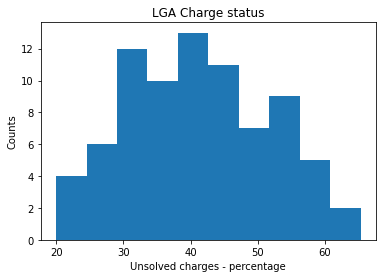

NormaltestResult(statistic=0.4710050453263719, pvalue=0.790173669664268)


In [15]:
plt.hist(unsolved_percentage)
plt.xlabel("Unsolved charges - percentage")
plt.ylabel("Counts")
plt.style.use("default")
plt.title("LGA Charge status")
plt.show()
print(st.normaltest(unsolved_percentage.sample(50)))

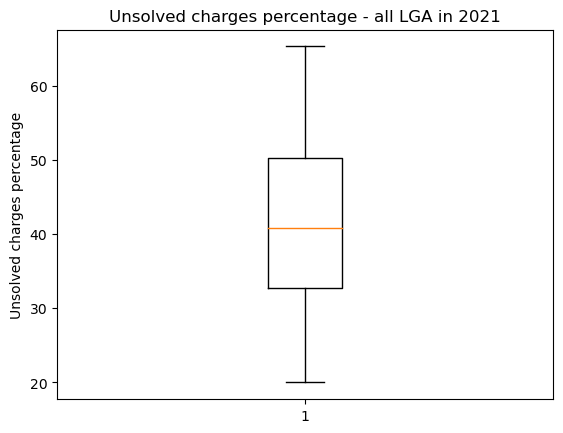

In [16]:
fig , ax = plt.subplots()
ax.set_title("Unsolved charges percentage - all LGA in 2021")
ax.set_ylabel("Unsolved charges percentage")
ax.boxplot(unsolved_percentage)
plt.show()

### Conclusion:
Data is normally distributed, no outliner identified

In [17]:
# setting up function to show scatter plot by year
def scatter_plot(df, year, chargetype, col1, col2):
    new_df = df.loc[(df["Charge Status"] == chargetype) & (df["Year"] == year)]
    title = str(f"{col1} vs {col2} \n {chargetype} charges - {year}")
    new_df.plot(col1, col2, kind = "scatter", xlabel = col1, title = title)
                
    (slope, intercept, rvalue, pvalue, stderr) = linregress(new_df[col1],new_df[col2])
    equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
    x = np.arange(0,new_df[col1].max()+1,1)
    y = [slope * x1 + intercept for x1 in x]
    
    plt.plot(x, y, color = "red" )
    plt.tight_layout()
    plt.style.use("Solarize_Light2")
    plt.annotate(equation, (new_df[col1].max()/3*2 , new_df[col2].max()/3), color = "red")
    print(f"r-value is %.2f" %rvalue)

r-value is -0.45


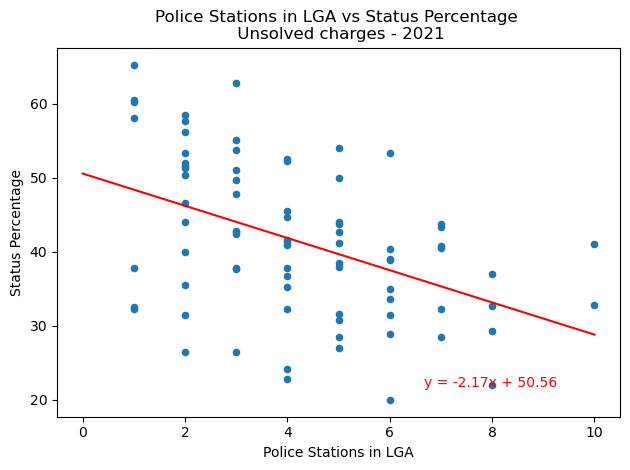

In [18]:
scatter_plot(LGA_charge_status_ps_df, 2021, "Unsolved", "Police Stations in LGA","Status Percentage")


r-value is 0.45


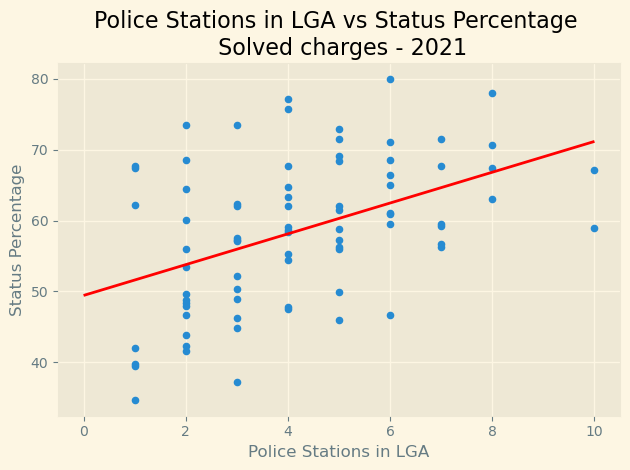

In [19]:
scatter_plot(LGA_charge_status_ps_df, 2021, "Solved", "Police Stations in LGA","Status Percentage")

r-value is 0.50


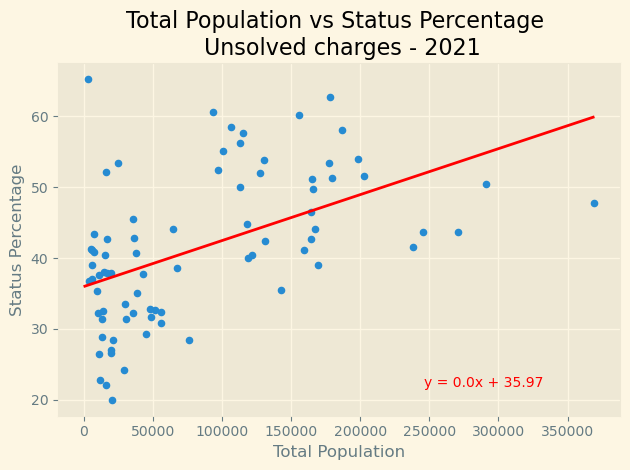

In [20]:
scatter_plot(LGA_charge_status_ps_df, 2021, "Unsolved", "Total Population", "Status Percentage")

r-value is -0.50


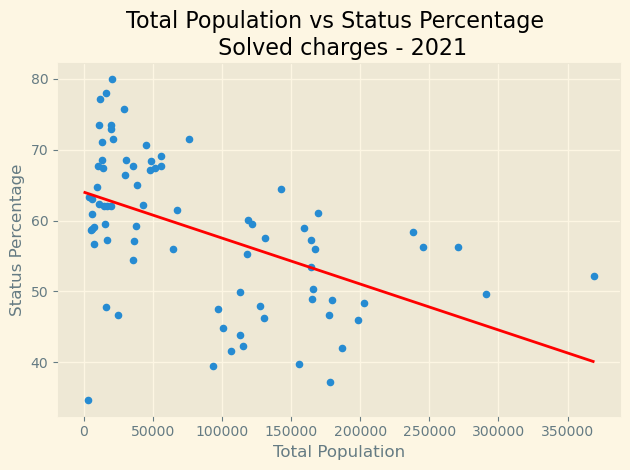

In [21]:
scatter_plot(LGA_charge_status_ps_df, 2021, "Solved", "Total Population", "Status Percentage")

# Getting charge percentage and population dataframe for regions

In [22]:
# Allocate LGA data to regions
LGA_by_Regions_df = pd.read_csv("../Output_data/LGA_by_Regions_2012-2021.csv")
LGA_by_Regions_df

,Year,Police Region,Local Government Area
0,2021,1 North West Metro,Banyule
1,2021,1 North West Metro,Brimbank
2,2021,1 North West Metro,Darebin
3,2021,1 North West Metro,Hobsons Bay
4,2021,1 North West Metro,Hume
...,...,...,...
865,2012,4 Western,Total
866,2012,Justice Institutions and Immigration Facilities,Justice Institutions and Immigration Facilities
867,2012,Justice Institutions and Immigration Facilities,Total
868,2012,Unincorporated Vic,Unincorporated Vic


In [23]:

LGA_charge_status_df = LGA_charge_status_df.rename(columns = {"Total Population" : "Total Population-LGA",
                                                              "Incidents Combined" :"Incidents Combined-LGA",
                                                              "Status Percentage" : "Status Percentage-LGA"})

In [24]:

region_charge_status_df = pd.merge(LGA_by_Regions_df, LGA_charge_status_df, how = "right", on = ("Year","Local Government Area"))
region_charge_status_df
                                   

,Year,Police Region,Local Government Area,Total Population-LGA,Charge Status,Incidents Combined-LGA,Total Incidents-LGA,Status Percentage-LGA
0,2012,2 Eastern,Alpine,12182,Solved,196,311,63.02
1,2012,2 Eastern,Alpine,12182,Unsolved,115,311,36.98
2,2013,2 Eastern,Alpine,12282,Solved,219,336,65.18
3,2013,2 Eastern,Alpine,12282,Unsolved,117,336,34.82
4,2014,2 Eastern,Alpine,12354,Solved,218,316,68.99
...,...,...,...,...,...,...,...,...
1575,2019,4 Western,Yarriambiack,6636,Unsolved,92,303,30.36
1576,2020,4 Western,Yarriambiack,6587,Solved,222,335,66.27
1577,2020,4 Western,Yarriambiack,6587,Unsolved,113,335,33.73
1578,2021,4 Western,Yarriambiack,6445,Solved,201,319,63.01


In [25]:
Regions_population_df = pd.read_csv("../Output_data/Population_by_Regions_2012-2021.csv")
region_charge_pop_df = pd.merge(region_charge_status_df, Regions_population_df , how = "left" , on = ("Police Region", "Year"))
region_charge_pop_df = region_charge_pop_df.rename(columns = {"Total Population":"Total Population-Regions"})

regions_charge_gb = region_charge_pop_df.groupby(["Year", "Police Region", "Charge Status"])

incident_by_charge = regions_charge_gb["Incidents Combined-LGA"].sum()
total_incident_by_region = regions_charge_gb["Total Incidents-LGA"].sum()

regions_charge_df = pd.DataFrame({"Status Percentage-Region": incident_by_charge/total_incident_by_region*100})
regions_charge_df.reset_index(level = [0,1,2],inplace = True)                 
region_charge_pop_df = pd.merge(regions_charge_df, region_charge_pop_df, how = "right" , on = ("Police Region", "Year", "Charge Status"))
region_charge_pop_df

,Year,Police Region,Charge Status,Status Percentage-Region,Local Government Area,Total Population-LGA,Incidents Combined-LGA,Total Incidents-LGA,Status Percentage-LGA,Total Population-Regions
0,2012,2 Eastern,Solved,47.859167,Alpine,12182,196,311,63.02,1573137
1,2012,2 Eastern,Unsolved,52.140833,Alpine,12182,115,311,36.98,1573137
2,2013,2 Eastern,Solved,50.380849,Alpine,12282,219,336,65.18,1591663
3,2013,2 Eastern,Unsolved,49.619151,Alpine,12282,117,336,34.82,1591663
4,2014,2 Eastern,Solved,53.422714,Alpine,12354,218,316,68.99,1610207
...,...,...,...,...,...,...,...,...,...,...
1575,2019,4 Western,Unsolved,39.495495,Yarriambiack,6636,92,303,30.36,1011124
1576,2020,4 Western,Solved,62.717842,Yarriambiack,6587,222,335,66.27,1025396
1577,2020,4 Western,Unsolved,37.282158,Yarriambiack,6587,113,335,33.73,1025396
1578,2021,4 Western,Solved,60.803545,Yarriambiack,6445,201,319,63.01,1037326


In [54]:
unsolved_region_charge_pop_df = region_charge_pop_df.loc[region_charge_pop_df["Charge Status"] == "Unsolved"]
unsolved_region_charge_pop_df = unsolved_region_charge_pop_df.drop_duplicates(subset = ("Year","Police Region"), keep = "first")

unsolved_region_charge_pop_df = unsolved_region_charge_pop_df[["Year","Police Region","Status Percentage-Region","Total Population-Regions"]]
unsolved_region_charge_pop_df.head()

,Year,Police Region,Status Percentage-Region,Total Population-Regions
1,2012,2 Eastern,52.140833,1573137
3,2013,2 Eastern,49.619151,1591663
5,2014,2 Eastern,46.577286,1610207
7,2015,2 Eastern,45.283093,1630219
9,2016,2 Eastern,45.321954,1654999


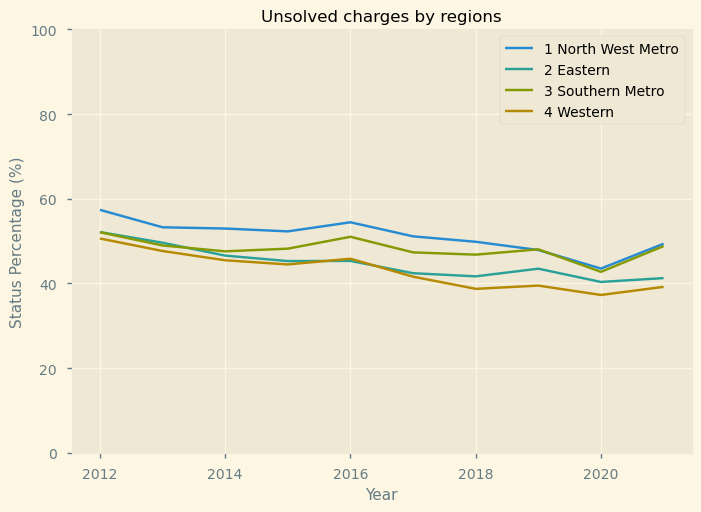

In [55]:
# fig, ax = plt.subplot(figsize = (15,15))

for name, data in unsolved_region_charge_pop_df.groupby("Police Region"):
    plt.plot(data["Year"], data["Status Percentage-Region"], label = name)
plt.xlabel("Year")
plt.ylabel("Status Percentage (%)")
plt.ylim(0,100)
plt.title("Unsolved charges by regions")
plt.style.use("seaborn-notebook")
plt.legend()
plt.show()

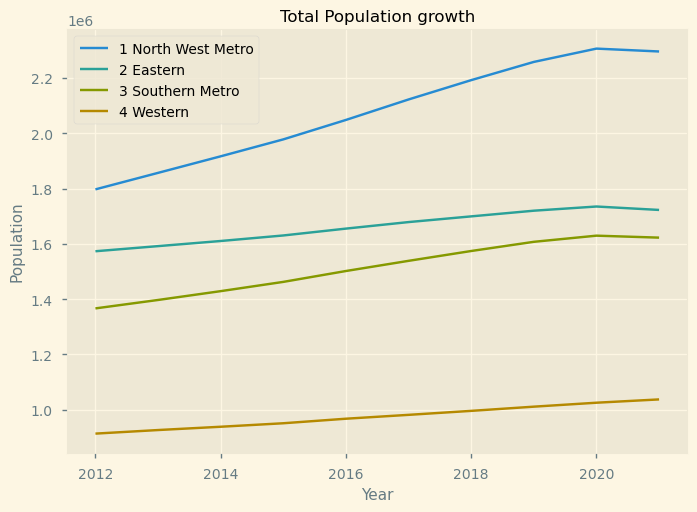

In [28]:
# fig, ax = plt.subplot(figsize = (15,15))

for name, data in unsolved_region_charge_pop_df.groupby("Police Region"):
    plt.plot(data["Year"], data["Total Population-Regions"], label = name)
plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Total Population growth")
plt.style.use("seaborn-notebook")
plt.legend()
plt.show()

# Draw LGA boundaries and show charges status on the map

In [29]:
# # getting LGA boundaries
# url = "https://data.gov.au/geoserver/vic-local-government-areas-psma-administrative-boundaries/wfs?request=GetFeature&typeName=ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811&outputFormat=json"
# response = requests.get(url).json()

# # # Save response to local Data folder
# with open('../Data/LGA_boundaries.json', 'w') as json_file:
#     json.dump(response, json_file)

In [30]:
boundaries = gpd.read_file('../Data/LGA_boundaries.json')

LGA_boundaries = boundaries[["vic_lga__3", "geometry"]]
LGA_boundaries = LGA_boundaries.rename(columns = {"vic_lga__3": "LGA"} )

LGA_boundaries["LGA"] = LGA_boundaries["LGA"].str.title()

LGA_boundaries["LGA"] = LGA_boundaries["LGA"].replace("Colac Otway","Colac-Otway")

LGA_boundaries

,LGA,geometry
0,Falls Creek Alpine Resort (Uninc),"MULTIPOLYGON (((147.24172 -36.86703, 147.24202..."
1,Mount Buller Alpine Resort (Uninc),"MULTIPOLYGON (((146.46042 -37.12999, 146.46062..."
2,Corangamite,"MULTIPOLYGON (((143.47180 -38.28086, 143.47117..."
3,Kingston,"MULTIPOLYGON (((145.10925 -38.04438, 145.10912..."
4,Frankston,"MULTIPOLYGON (((145.10531 -38.15533, 145.10556..."
...,...,...
87,Towong,"MULTIPOLYGON (((147.30588 -36.73235, 147.30692..."
88,Queenscliffe,"MULTIPOLYGON (((144.60074 -38.28784, 144.60235..."
89,French-Elizabeth-Sandstone Islands (Uninc),"MULTIPOLYGON (((145.45333 -38.30788, 145.45341..."
90,Mount Stirling Alpine Resort (Uninc),"MULTIPOLYGON (((146.45474 -37.12387, 146.45427..."


In [31]:
solved_charge_percentage = LGA_charge_status_ps_df.loc[LGA_charge_status_ps_df["Charge Status"] == "Unsolved"]
solved_charge_percentage = solved_charge_percentage[["Local Government Area", "Status Percentage"]]
solved_charge_percentage = solved_charge_percentage.rename(columns = {"Local Government Area":"LGA"})
solved_charge_percentage

,LGA,Status Percentage
1,Alpine,28.84
3,Ararat,22.84
5,Ballarat,50.01
7,Banyule,42.43
9,Bass Coast,35.03
...,...,...
149,Wodonga,37.76
151,Wyndham,50.41
153,Yarra,55.14
155,Yarra Ranges,41.07


In [32]:
LGA_boundaries = LGA_boundaries.merge(solved_charge_percentage,how = "left" , on = "LGA")

In [33]:
LGA_boundaries.loc[LGA_boundaries["Status Percentage"].isna()]

,LGA,geometry,Status Percentage
0,Falls Creek Alpine Resort (Uninc),"MULTIPOLYGON (((147.24172 -36.86703, 147.24202...",NaN
1,Mount Buller Alpine Resort (Uninc),"MULTIPOLYGON (((146.46042 -37.12999, 146.46062...",NaN
41,Mount Hotham Alpine Resort (Uninc),"MULTIPOLYGON (((147.14840 -37.00947, 147.14830...",NaN
72,Mount Baw Baw Alpine Resort (Uninc),"MULTIPOLYGON (((146.24954 -37.84882, 146.24667...",NaN
77,Lake Mountain Alpine Resort (Uninc),"MULTIPOLYGON (((145.83687 -37.53191, 145.83703...",NaN
83,Gabo Island (Uninc),"MULTIPOLYGON (((149.91540 -37.56891, 149.91513...",NaN
84,French-Elizabeth-Sandstone Islands (Uninc),"MULTIPOLYGON (((145.36957 -38.41265, 145.36940...",NaN
85,French-Elizabeth-Sandstone Islands (Uninc),"MULTIPOLYGON (((145.20850 -38.32791, 145.20853...",NaN
89,French-Elizabeth-Sandstone Islands (Uninc),"MULTIPOLYGON (((145.45333 -38.30788, 145.45341...",NaN
90,Mount Stirling Alpine Resort (Uninc),"MULTIPOLYGON (((146.45474 -37.12387, 146.45427...",NaN


In [34]:
LGA_boundaries = LGA_boundaries.dropna()

In [35]:
LGA_boundaries

,LGA,geometry,Status Percentage
2,Corangamite,"MULTIPOLYGON (((143.47180 -38.28086, 143.47117...",40.46
3,Kingston,"MULTIPOLYGON (((145.10925 -38.04438, 145.10912...",49.71
4,Frankston,"MULTIPOLYGON (((145.10531 -38.15533, 145.10556...",35.52
5,Golden Plains,"MULTIPOLYGON (((144.08423 -38.11006, 144.08378...",53.38
6,Moira,"MULTIPOLYGON (((146.21053 -36.11529, 146.21009...",33.57
...,...,...,...
82,Port Phillip,"MULTIPOLYGON (((144.95341 -37.85080, 144.95321...",56.21
86,Banyule,"MULTIPOLYGON (((145.13566 -37.74089, 145.13561...",42.43
87,Towong,"MULTIPOLYGON (((147.30588 -36.73235, 147.30692...",41.18
88,Queenscliffe,"MULTIPOLYGON (((144.60074 -38.28784, 144.60235...",65.28


In [36]:
len(LGA_boundaries)

82

In [37]:
# There should be 79 LGAs
LGA_boundaries.drop_duplicates(subset="LGA", keep = "first", inplace=True)

In [38]:
with open('../Data/VMFEAT_POLICE_STATION.json') as f:
    js = json.load(f)
policeStations = gpd.read_file('../Data/VMFEAT_POLICE_STATION.json')

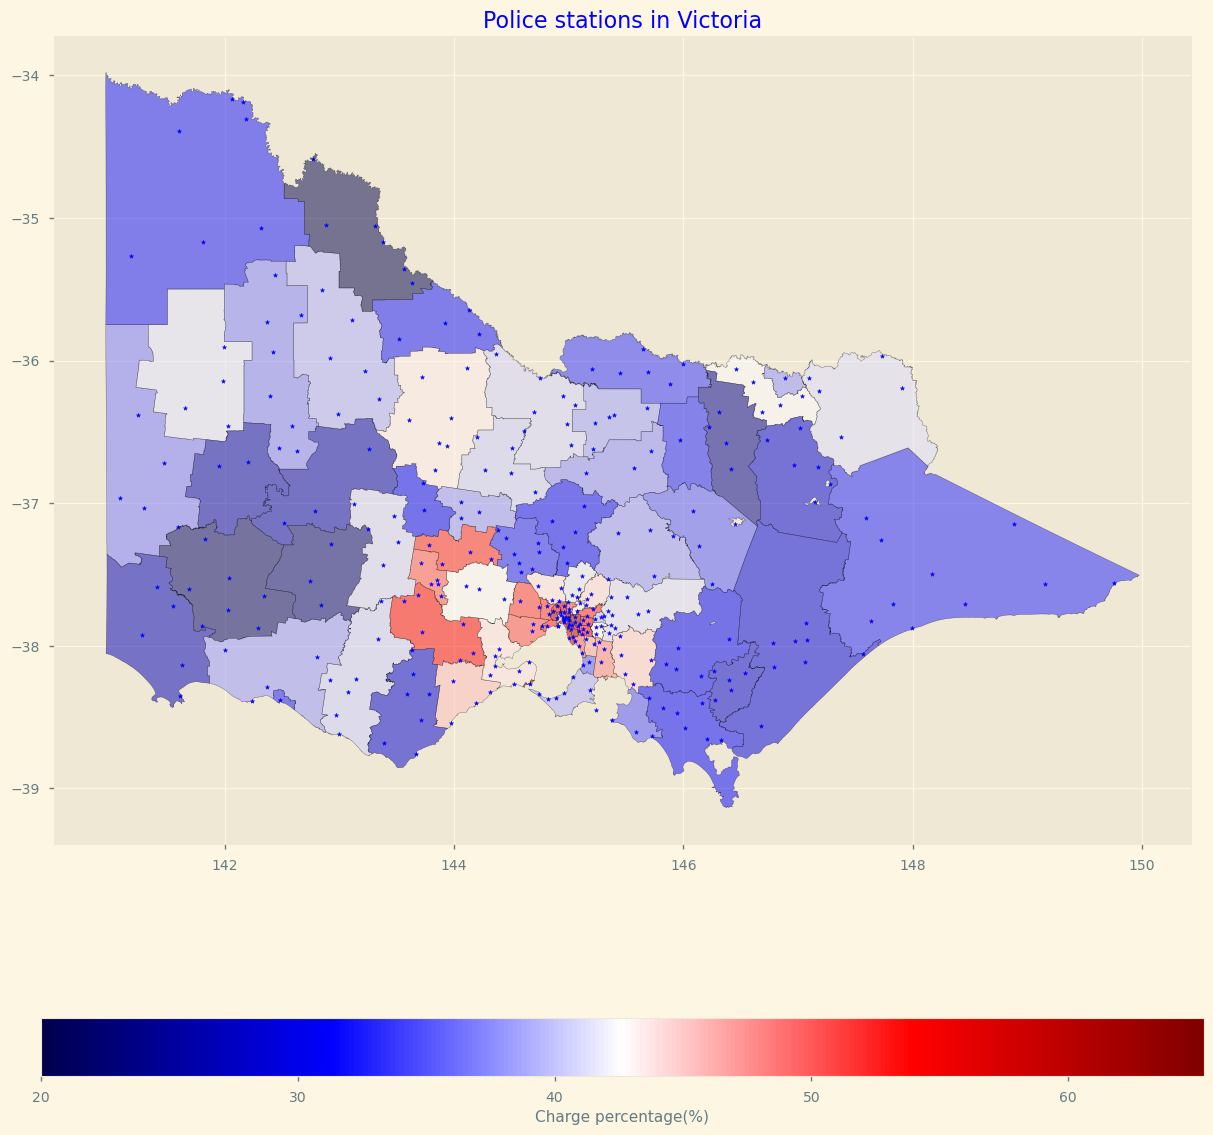

In [39]:
f, ax = plt.subplots(1, figsize = (15,15))
# plt.style.use("seaborn-notebook") #"Solarize_Light2"
LGA_boundaries.plot("Status Percentage", cmap = "seismic", ax = ax, legend = True, 
                        edgecolor = "black", alpha = 0.5, legend_kwds={'label': "Charge percentage(%)",
                                                                  'orientation': "horizontal"
                                                                      })
policeStations.plot(ax = ax, color = "blue", marker = "*", markersize = 10)
plt.title("Police stations in Victoria", fontdict = {'fontsize' : 16, 'color': "blue"})
plt.style.use("seaborn-notebook")#"Solarize_Light2"
# plt.show_legend()
plt.show()

In [40]:
# # Map for readme file
# LGA_boundaries.explore(scheme="naturalbreaks")

# Getting Administrative Region boundaries

In [41]:
# # getting regions boundaries
# url = "https://vicroadsopendata-vicroadsmaps.opendata.arcgis.com/datasets/a6e912737f234c5b825242ceb19a33b1_0.geojson?outSR=%7B%22latestWkid%22%3A3111%2C%22wkid%22%3A102171%7D"
# response = requests.get(url).json()

# # # Save response to local Data folder
# with open('../Data/region_boundaries.json', 'w') as json_file:
#     json.dump(response, json_file)

In [42]:
region_boundaries = gpd.read_file('../Data/region_boundaries.json')

In [43]:
region_boundaries

,OBJECTID,REG_NUM,REG_NAME,ABB_NAME,Shape__Area,Shape__Length,GlobalID,geometry
0,23,5,METROPOLITAN SOUTH EAST REGION,METRO SOUTH EAST,5.825078e+09,7.240859e+05,68532a6c-7ae8-470d-953a-c13c907e3cf7,"POLYGON ((145.42608 -37.53461, 145.42600 -37.5..."
1,24,6,SOUTH WESTERN REGION,SOUTH WESTERN,3.183561e+10,1.455915e+06,705cefb2-79f6-47a6-8eee-3d29e34dfaeb,"POLYGON ((142.20729 -37.08382, 142.20732 -37.0..."
2,25,8,METROPOLITAN NORTH WEST REGION,METRO NORTH WEST,3.001713e+09,4.022361e+05,d3409932-e42d-4f6f-a50f-6dcfe8497469,"POLYGON ((145.12108 -37.40874, 145.12272 -37.4..."
3,26,1,EASTERN REGION,EASTERN,4.135622e+10,2.044252e+06,28bf8419-ef0b-4e57-82ed-22e8b4a02803,"MULTIPOLYGON (((147.99030 -36.63516, 148.13450..."
4,27,2,WESTERN REGION,WESTERN,6.954342e+10,2.194659e+06,973abfa6-03e4-4baf-987d-a4fff9cd5f15,"POLYGON ((140.97137 -33.99842, 140.97140 -33.9..."
5,28,3,NORTH EASTERN REGION,NORTH EASTERN,3.751188e+10,1.739253e+06,08e89199-9d97-4bf6-b042-9bb8d40aed83,"POLYGON ((145.53407 -35.80529, 145.53390 -35.8..."
6,29,4,NORTHERN REGION,NORTHERN,3.819840e+10,1.882613e+06,7189e0f4-a3f5-4be4-9e29-ec1439a4466c,"POLYGON ((142.74932 -34.57580, 142.74955 -34.5..."


Text(0.5, 1.0, 'Administrative boundaries in Victoria')

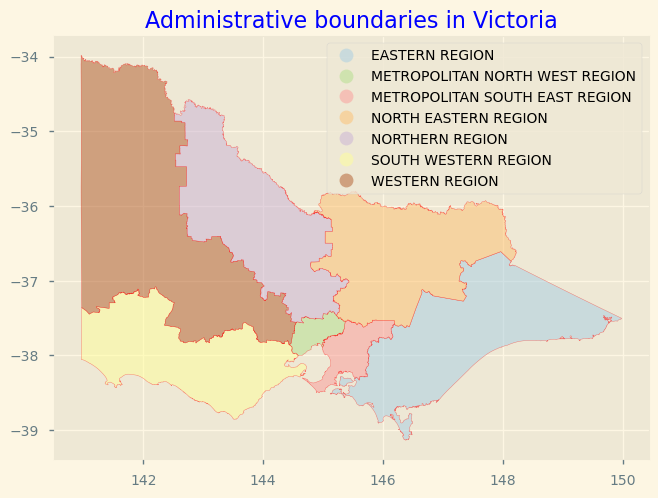

In [44]:
region_boundaries.plot(column = "REG_NAME",cmap = "Paired",legend = True, edgecolor = "red", alpha = 0.5)
plt.title("Administrative boundaries in Victoria", fontdict = {'fontsize' : 16, 'color': "blue"})

# Getting Administrative Region boundaries

In [45]:
# getting region boundaries
LGA_by_Regions_df = LGA_by_Regions_df.loc[LGA_by_Regions_df["Year"]==2021]
LGA_by_Regions_df = LGA_by_Regions_df.rename(columns = {"Local Government Area":"LGA"})

In [46]:
LGA_by_Regions_df

,Year,Police Region,LGA
0,2021,1 North West Metro,Banyule
1,2021,1 North West Metro,Brimbank
2,2021,1 North West Metro,Darebin
3,2021,1 North West Metro,Hobsons Bay
4,2021,1 North West Metro,Hume
...,...,...,...
82,2021,4 Western,Total
83,2021,Justice Institutions and Immigration Facilities,Justice Institutions and Immigration Facilities
84,2021,Justice Institutions and Immigration Facilities,Total
85,2021,Unincorporated Vic,Unincorporated Vic


In [47]:
regions = LGA_boundaries.merge(LGA_by_Regions_df, how = "left", on = "LGA")

In [48]:
regions

,LGA,geometry,Status Percentage,Year,Police Region
0,Corangamite,"MULTIPOLYGON (((143.47180 -38.28086, 143.47117...",40.46,2021,4 Western
1,Kingston,"MULTIPOLYGON (((145.10925 -38.04438, 145.10912...",49.71,2021,3 Southern Metro
2,Frankston,"MULTIPOLYGON (((145.10531 -38.15533, 145.10556...",35.52,2021,3 Southern Metro
3,Golden Plains,"MULTIPOLYGON (((144.08423 -38.11006, 144.08378...",53.38,2021,4 Western
4,Moira,"MULTIPOLYGON (((146.21053 -36.11529, 146.21009...",33.57,2021,2 Eastern
...,...,...,...,...,...
74,Port Phillip,"MULTIPOLYGON (((144.95341 -37.85080, 144.95321...",56.21,2021,3 Southern Metro
75,Banyule,"MULTIPOLYGON (((145.13566 -37.74089, 145.13561...",42.43,2021,1 North West Metro
76,Towong,"MULTIPOLYGON (((147.30588 -36.73235, 147.30692...",41.18,2021,2 Eastern
77,Queenscliffe,"MULTIPOLYGON (((144.60074 -38.28784, 144.60235...",65.28,2021,4 Western


In [49]:
regions = regions[["Police Region" , "geometry"]]
PSA_regions_boundaries = regions.dissolve(by = "Police Region")

PSA_regions_boundaries.reset_index(level = [0], inplace= True)

PSA_regions_boundaries

,Police Region,geometry
0,1 North West Metro,"POLYGON ((144.54494 -37.97236, 144.54462 -37.9..."
1,2 Eastern,"POLYGON ((146.00779 -38.82945, 146.00768 -38.8..."
2,3 Southern Metro,"POLYGON ((145.22177 -38.37734, 145.22178 -38.3..."
3,4 Western,"POLYGON ((143.94605 -38.57955, 143.94600 -38.5..."


Text(0.5, 1.0, 'Police Service Area boundaries in Victoria')

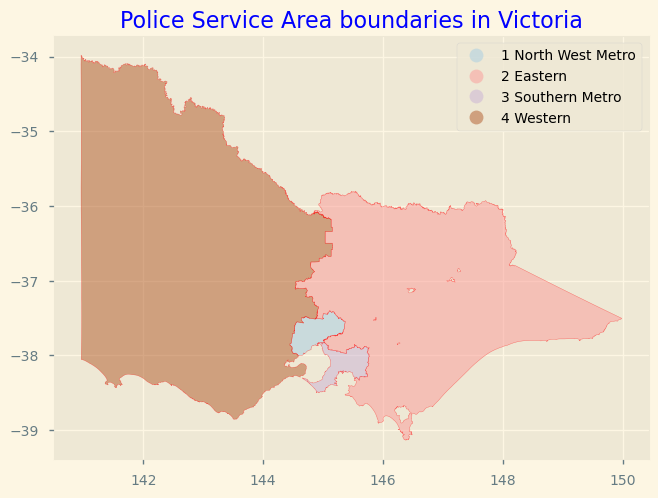

In [50]:
PSA_regions_boundaries.plot(column = "Police Region",cmap = "Paired",legend = True, edgecolor = "red", alpha = 0.5)
plt.title("Police Service Area boundaries in Victoria", fontdict = {'fontsize' : 16, 'color': "blue"})

Text(0.5, 1.0, 'Police stations in Victoria')

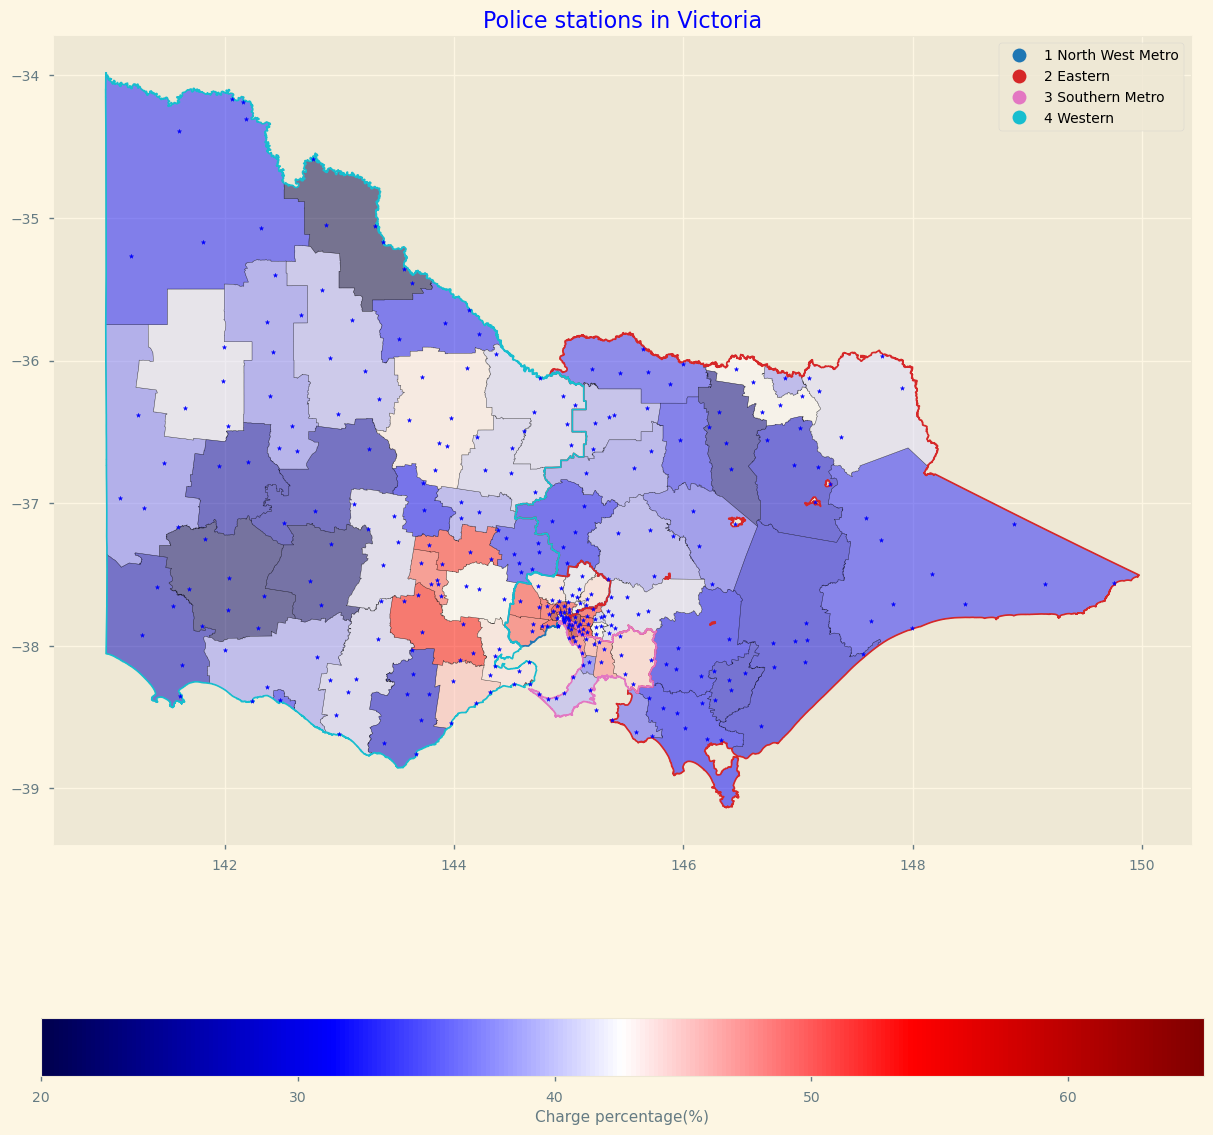

In [51]:
f, ax = plt.subplots(1, figsize = (15,15))
plt.style.use("seaborn-notebook") #"Solarize_Light2"
LGA_boundaries.plot("Status Percentage", cmap = "seismic", ax = ax, legend = True, 
                        edgecolor = "black", alpha = 0.5, legend_kwds={'label': "Charge percentage(%)",
                                                                  'orientation': "horizontal",
                                                                      })
PSA_regions_boundaries.plot("Police Region", ax = ax, facecolor = "none", edgecolor = "black", linewidth = 1.2, legend = True)
policeStations.plot(ax = ax, color = "blue", marker = "*", markersize = 10)
plt.title("Police stations in Victoria", fontdict = {'fontsize' : 16, 'color': "blue"})
